In [1]:
#Creating Aperture Objects

In [2]:
from photutils.aperture import CircularAperture
positions = [(30., 30.), (40., 40.)]
aperture = CircularAperture(positions, r=3.)

from astropy import units as u
from astropy.coordinates import SkyCoord
from photutils.aperture import SkyCircularAperture
positions = SkyCoord(l=[1.2, 2.3] * u.deg, b=[0.1, 0.2] * u.deg, frame='galactic')
aperture = SkyCircularAperture(positions, r=4. * u.arcsec)

Here we create a circular aperture in pixel coodinates. Seen above, we have 2 separate positions, (x,y) (30,30) and (40,40) both having a radius of 3. Next using astropy, we create a circular sky aperture.

In [3]:
#Performing Aperture Photometry

In [4]:
positions = [(30., 30.), (40., 40.)]
aperture = CircularAperture(positions, r=3.)

In [5]:
import numpy as np
from photutils.aperture import aperture_photometry
data = np.ones((100, 100))
phot_table = aperture_photometry(data, aperture)
phot_table['aperture_sum'].info.format = '%.8g'  # for consistent table output
print(phot_table)

 id xcenter ycenter aperture_sum
      pix     pix               
--- ------- ------- ------------
  1    30.0    30.0    28.274334
  2    40.0    40.0    28.274334


In [6]:
print(np.pi * 3. ** 2)

28.274333882308138


We first define the positions we want for our apertures and how big the radius is. Since we are using a 100x100 frame we define data as an array of 100x100. We result with the position of the apertures and their sum of light received. Since each value is 1 the sum is equal to the area of each aperture as seen above.

In [7]:
#Aperture and Pixel Overlap

In [8]:
>>> phot_table = aperture_photometry(data, aperture, method='subpixel',
...                                  subpixels=5)
>>> print(phot_table)

 id xcenter ycenter aperture_sum
      pix     pix               
--- ------- ------- ------------
  1    30.0    30.0        27.96
  2    40.0    40.0        27.96


Here we have the same data as the data used in the prior cells, but we use subpixels instead of the exact method to get the number of pixels in the aperture. The subpixel method is faster but not as precise since it only takes into account subpixels whos centers are within the aperture, that's why we see a smaller result than the number from before.

In [9]:
#Multiple Apertures at Each Position

In [10]:
>>> radii = [3., 4., 5.]
>>> apertures = [CircularAperture(positions, r=r) for r in radii]
>>> phot_table = aperture_photometry(data, apertures)
>>> for col in phot_table.colnames:
...     phot_table[col].info.format = '%.8g'  # for consistent table output
>>> print(phot_table)

 id xcenter ycenter aperture_sum_0 aperture_sum_1 aperture_sum_2
      pix     pix                                               
--- ------- ------- -------------- -------------- --------------
  1      30      30      28.274334      50.265482      78.539816
  2      40      40      28.274334      50.265482      78.539816


In the cell above, we use a forloop to run through three different sets of radii and get the aperture sum for all 3 radii for the two apertures we have.

In [11]:
>>> from photutils.aperture import EllipticalAperture
>>> a = 5.
>>> b = 3.
>>> theta = np.pi / 4.
>>> apertures = EllipticalAperture(positions, a, b, theta)
>>> phot_table = aperture_photometry(data, apertures)
>>> for col in phot_table.colnames:
...     phot_table[col].info.format = '%.8g'  # for consistent table output
>>> print(phot_table)

 id xcenter ycenter aperture_sum
      pix     pix               
--- ------- ------- ------------
  1      30      30     47.12389
  2      40      40     47.12389


Here we create an elliptical aperture where we need to define its boundries in eliptacal coordinates, (a,b,theta) and with the following values we got the following swum.

In [12]:
>>> a = [5., 6., 7.]
>>> b = [3., 4., 5.]
>>> theta = np.pi / 4.
>>> apertures = [EllipticalAperture(positions, a=ai, b=bi, theta=theta)
...              for (ai, bi) in zip(a, b)]
>>> phot_table = aperture_photometry(data, apertures)
>>> for col in phot_table.colnames:
...     phot_table[col].info.format = '%.8g'  # for consistent table output
>>> print(phot_table)

 id xcenter ycenter aperture_sum_0 aperture_sum_1 aperture_sum_2
      pix     pix                                               
--- ------- ------- -------------- -------------- --------------
  1      30      30       47.12389      75.398224      109.95574
  2      40      40       47.12389      75.398224      109.95574


Here is another example of how to use an array and create a for loop that gets the aperture sum for each elliptical aperture with different a and b values.

In [13]:
#Background Subtraction

In [14]:
>>> phot_table = aperture_photometry(data - bkg, aperture)  

NameError: name 'bkg' is not defined

In [15]:
>>> from photutils.aperture import CircularAnnulus
>>> aperture = CircularAperture(positions, r=3)
>>> annulus_aperture = CircularAnnulus(positions, r_in=6., r_out=8.)

In the cell above we create the local background by creating a circular annulus with the given inner and outer radii.

In [16]:
>>> apers = [aperture, annulus_aperture]
>>> phot_table = aperture_photometry(data, apers)
>>> for col in phot_table.colnames:
...     phot_table[col].info.format = '%.8g'  # for consistent table output
>>> print(phot_table)

 id xcenter ycenter aperture_sum_0 aperture_sum_1
      pix     pix                                
--- ------- ------- -------------- --------------
  1      30      30      28.274334      87.964594
  2      40      40      28.274334      87.964594


Aperture sum 1 is the area contained in the annulus.

In [17]:
>>> bkg_mean = phot_table['aperture_sum_1'] / annulus_aperture.area

In [18]:
>>> bkg_sum = bkg_mean * aperture.area
>>> final_sum = phot_table['aperture_sum_0'] - bkg_sum
>>> phot_table['residual_aperture_sum'] = final_sum
>>> phot_table['residual_aperture_sum'].info.format = '%.8g'  # for consistent table output
>>> print(phot_table['residual_aperture_sum'])  

residual_aperture_sum
---------------------
       -1.0658141e-14
       -1.0658141e-14


The method we used above is the photometry method you'd use to subtract the background. We got 0 when we subtracted the aperture sum with the background sum but that was becuase the sum is equal to its area since it just uses values of 1.

In [19]:
>>> from photutils.datasets import make_100gaussians_image
>>> from photutils.aperture import CircularAperture, CircularAnnulus
>>> data = make_100gaussians_image()
>>> positions = [(145.1, 168.3), (84.5, 224.1), (48.3, 200.3)]
>>> aperture = CircularAperture(positions, r=5)
>>> annulus_aperture = CircularAnnulus(positions, r_in=10, r_out=15)

Here we import an image and select three stars on the image with the given locations as 'positions'. We use an aperture radius of 5 and anulu of inner radius 10 and outer radius 15.

In [20]:
>>> annulus_masks = annulus_aperture.to_mask(method='center')

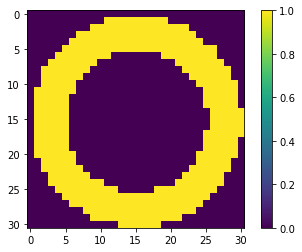

In [21]:
>>> import matplotlib.pyplot as plt
>>> plt.imshow(annulus_masks[0], interpolation='nearest')
>>> plt.colorbar()

What we did here is we used the 'mask' function to isolate the annulus and since we used the 'center' method, we only get values of 0 or 1. As you can see, it plots out the whole annulus with the dimensions it was given.

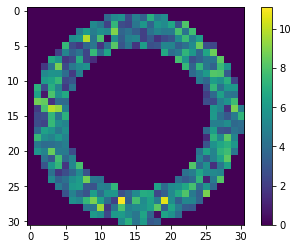

In [22]:
>>> annulus_data = annulus_masks[0].multiply(data)
>>> plt.imshow(annulus_data, interpolation='nearest')
>>> plt.colorbar()

By using the 'multiply(data)' function, we get the values of the pixels in the annulus

In [23]:
>>> mask = annulus_masks[0].data
>>> annulus_data_1d = annulus_data[mask > 0]
>>> annulus_data_1d.shape

(394,)

In [24]:
>>> from astropy.stats import sigma_clipped_stats
>>> _, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d)
>>> print(median_sigclip)

4.848212997882959


In [25]:
>>> background = median_sigclip * aperture.area
>>> print(background) 

380.7777584296913


In the first cell after the image, we sort all of the data points into a 1D array which gives us a sum of 394. With the 'sigma_clipped_stats' function, we get the median value of the background which is 4.84. With this we can find the background by multiply the average value of the background by the aperture area which gives us a value of 380.7.

In [26]:
>>> from astropy.stats import sigma_clipped_stats
>>> from photutils.aperture import aperture_photometry
>>> from photutils.aperture import CircularAperture, CircularAnnulus
>>> from photutils.datasets import make_100gaussians_image
>>>
>>> data = make_100gaussians_image()
>>> positions = [(145.1, 168.3), (84.5, 224.1), (48.3, 200.3)]
>>> aperture = CircularAperture(positions, r=5)
>>> annulus_aperture = CircularAnnulus(positions, r_in=10, r_out=15)
>>> annulus_masks = annulus_aperture.to_mask(method='center')
>>>
>>> bkg_median = []
>>> for mask in annulus_masks:
...     annulus_data = mask.multiply(data)
...     annulus_data_1d = annulus_data[mask.data > 0]
...     _, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d)
...     bkg_median.append(median_sigclip)
>>> bkg_median = np.array(bkg_median)
>>> phot = aperture_photometry(data, aperture)
>>> phot['annulus_median'] = bkg_median
>>> phot['aper_bkg'] = bkg_median * aperture.area
>>> phot['aper_sum_bkgsub'] = phot['aperture_sum'] - phot['aper_bkg']
>>> for col in phot.colnames:
...     phot[col].info.format = '%.8g'  # for consistent table output
>>> print(phot)

 id xcenter ycenter aperture_sum annulus_median  aper_bkg aper_sum_bkgsub
      pix     pix                                                        
--- ------- ------- ------------ -------------- --------- ---------------
  1   145.1   168.3    1131.5794       4.848213 380.77776       750.80166
  2    84.5   224.1    746.16064      5.0884354 399.64478       346.51586
  3    48.3   200.3    1250.2186      4.8060599 377.46706        872.7515


In the cell above, we basically did everything we did before but in one cell. We extract the image, locate the positions of the stars, and set the radii for the aperture and annulus. In the forloop, we set up the functions we used before to find the median background value and subtract the sum from the aperture value for all three stars. In the end we print out a table that displays the information for all three stars.

In [27]:
#Error Estimation

In [28]:
>>> positions = [(30., 30.), (40., 40.)]
>>> aperture = CircularAperture(positions, r=3.)
>>> data = np.ones((100, 100))
>>> error = 0.1 * data

>>> phot_table = aperture_photometry(data, aperture, error=error)
>>> for col in phot_table.colnames:
...     phot_table[col].info.format = '%.8g'  # for consistent table output
>>> print(phot_table)

 id xcenter ycenter aperture_sum aperture_sum_err
      pix     pix                                
--- ------- ------- ------------ ----------------
  1      30      30    28.274334       0.53173616
  2      40      40    28.274334       0.53173616


In [29]:
>>> from photutils.utils import calc_total_error
>>> effective_gain = 500  # seconds
>>> error = calc_total_error(data, bkg_error, effective_gain)  
>>> phot_table = aperture_photometry(data - bkg, aperture, error=error)  

NameError: name 'bkg_error' is not defined

This section gives us the error estimation for any of the pixel values. In the first cell you get the sum of the error of all pixels in the aperture. Here the error is defined as .1*data and uses a particular function to find the error.

In [30]:
#Pixel Masking

In [31]:
>>> data = np.ones((5, 5))
>>> aperture = CircularAperture((2, 2), 2.)
>>> mask = np.zeros(data.shape, dtype=bool)
>>> data[2, 2] = 100.  # bad pixel
>>> mask[2, 2] = True
>>> t1 = aperture_photometry(data, aperture, mask=mask)
>>> t1['aperture_sum'].info.format = '%.8g'  # for consistent table output
>>> print(t1['aperture_sum'])

aperture_sum
------------
   11.566371


In [32]:
>>> t2 = aperture_photometry(data, aperture)
>>> t2['aperture_sum'].info.format = '%.8g'  # for consistent table output
>>> print(t2['aperture_sum'])

aperture_sum
------------
   111.56637


These two cells compare the difference between masking pixels (ignoring) from the aperture.